# Group 36 Project Proposal

### Group Members: Bhavtej Bhasin, Peter Chen, Theresa Choi, Sky Langille
### DSCI 100 004

In [1]:
#loading libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

**Proposed Title:** K-Nearest Neighbor Regression Model for University Ranking Based on the Ratio of Female Students.

**Introduction:**
- Background Information:
    - University rankings are one of the first aspects viewed when students, their families or employers look into a prospective education or employee. These rankings are valued by many people including the university itself as through these filters and discoveries flaws, biases, or interesting variables can be found within the data. By diving deeper into how the female student ratio in universities around the world influence the school's ranking, more informed decisions can be made by prospective students of their choice of a post-secondary school, students can expect the kind of environment they will be entering and education they will be receiving. 
- Predictive Question:
    - Can global university ranking be predicted using the ratio of female students within the student body?
- Data Set:
    - The data set we have selected to use for this study is the World University Rankings 2023 data set published on Kaggle by Syed Ali Taqi in collaboration with Abdullah Sajid and Muhammad Jawad Awan. This set includes university rankings from across 104 countries which includes 1,799 indivdual universities. 
    - Original variables include:
        - Name of university
        - Location
        - Number of students
        - Number of students per staff
        - International student percentage
        - Female to male ratio (out of 100 count)
    - As well as scoring variables:
        - Overall score
        - Teaching score
        - Research score
        - Citation score
        - Industry income score
        - International outlook score

**Preliminary Data Analysis:**

In [39]:
#load dataset into R
university_data <- read_csv("World University Rankings 2023.csv")

Rows: 2341 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): University Rank, Name of University, Location, International Stude...
dbl  (1): No of student per staff
num  (1): No of student

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [40]:
#initial data wrangling
university_rename <- university_data |> #rename relevant columns
    rename(
       "university_rank" = "University Rank",
        "name_of_university" = "Name of University",
        "number_of_students" = "No of student",
        "number_students_per_staff" = "No of student per staff",
        "international_students" = "International Student",
        "femalemale_ratio" = "Female:Male Ratio"
    )

university_student_stats <- university_rename |> #create tibble with only relvant columns
    select(university_rank, name_of_university, number_of_students, number_students_per_staff, 
           international_students, femalemale_ratio) |>
    filter(university_rank != "Reporter") |> #filter out unranked universities
    filter(complete.cases(femalemale_ratio)) |> #filter out universities that did not report a student ratio
    mutate(university_rank = as.numeric(university_rank)) |>
    drop_na(university_rank) #filter out universities whose ranks are ranges (eg. 201-250)

university_separate <- university_student_stats |> #separate male and female student ratio into two columns
    separate(
        col = femalemale_ratio,
        into = c("female_student_ratio", "male_student_ratio"),
        sep = ":") |>
   mutate(female_student_ratio = as.numeric(female_student_ratio))

#separate tibble with only univeristy rank, name and female student ratio
university_female <- university_separate |> 
    select(university_rank, name_of_university, female_student_ratio)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `university_rank = as.numeric(university_rank)`.
Caused by warning:
! NAs introduced by coercion”


In [41]:
#split data into training and testing sets
set.seed(2023) #set seed DO NOT CHANGE!

university_split <- initial_split(university_female, prop = 0.70, strata = university_rank)
university_training <- training(university_split)
university_testing <- testing(university_split)

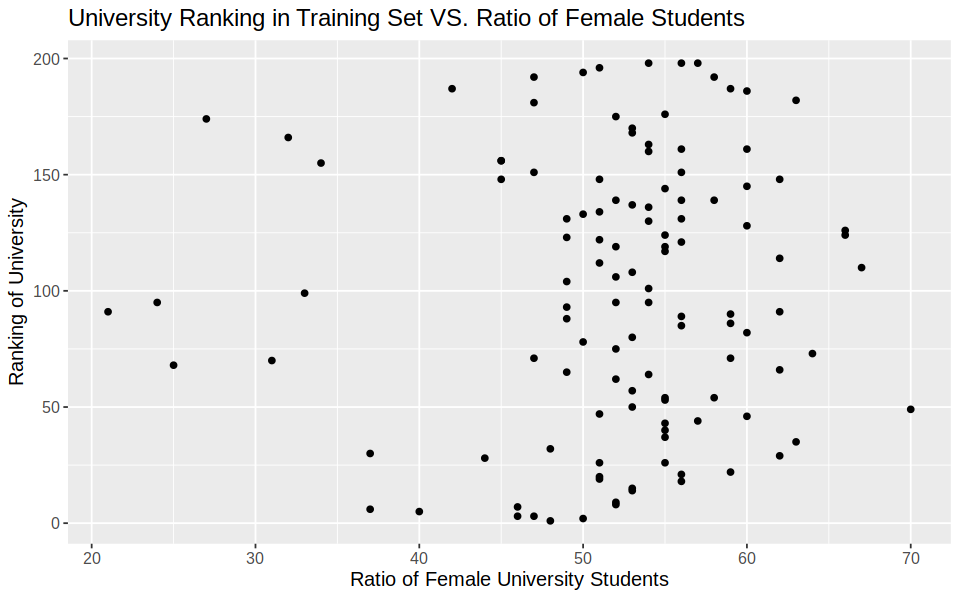

In [42]:
#generate scatterplot of university ranking vs. female student ratio
options(repr.plot.height = 5, repr.plot.width = 8) #set visualization dimensions

uni_ratio_plot <- university_training |> 
    ggplot(aes(x = female_student_ratio, y = university_rank)) +
    geom_point() +
    xlab("Ratio of Female University Students") +
    ylab("Ranking of University") +
    ggtitle("University Ranking in Training Set VS. Ratio of Female Students") +
    theme(text = element_text(size=12))
uni_ratio_plot

In [43]:
#summarize training set in one table
training_table <- university_training |>
    mutate(number_training_obs = nrow(university_training)) |>
    mutate(average_female_ratio = mean(female_student_ratio)) |>
    select(number_training_obs, average_female_ratio) |>
    slice(1)
training_table

number_training_obs,average_female_ratio
<int>,<dbl>
119,52.03361


**Methods:**

We want to construct and interpret a K-nearest neighbour (KNN) regression model to predict university ranking based on the ratio of female students variable. 
To achieve this, we will first preprocess that data. We need to extract the female student ratio column and the school ranking column. We need to convert the female student ratio to a numerical value and we standardise both the converted female student ratio value and the school ranking value.

Next, to construct the KNN regression, we exponentially select a list of odd values of K (3,7,13,25,49,97) as hyperparameters and run KNN regression. For each value of K, we will implement a 5-fold cross validation to test the RMSE. We will select the model with the best RMSE as our final model. Finally, we visualise the selected model line and the data point and on a 2D plot and we interpret the relationship between female ratio and the university ranking.


**Expected Outcomes and Significance:**

**Expected Outcomes:**
University rank within the global standing may be higher when the female to male student ratio is closer to being equal. Lower female to male student body ratios may result in lower global university ranking.

**Importance:**
There is a scarce amount of research focused on females, especially in scientific research and writings and reports, compared to studies, research and writings about males. So by diving into and adding to the research and analyses focused on females we add value and further the importance of scientific analyses and studies including/making women the focus.
By analyzing the female student ratio of the world's universities connections and correlations can be discovered leading to helpful insight for university applications, universities or regions to understand biases or imbalances, and even shine a light in ares of gender studies.

**Further questions and curiosities this analysis can lead to are:**
- Are there regional disparities? Do certain areas or countries have a more one-sided or more balanced ratio?
- How has the balance of female:male changed over time?
- Are certain subject focused schools more likely to have a majority of a certain sex?
- Are there correlations between the socioeconomic factors in the country or region that have a significant impact on the female:male ratio? If so, how do those come into play?
Many of these questions lead to a spiderweb of other factors and situations that come into play in a complex system of our society today. 